<a href="https://colab.research.google.com/github/aristanaya/200030702-forcasting/blob/main/test_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns



file_path = './Data Jumlah Penumpang Pesawat.csv'
data = pd.read_csv(file_path)

# Convert 'Tanggal' to datetime and set as index
data['Tanggal'] = pd.to_datetime(data['Tanggal'])
data['Penumpang'] = data['Penumpang'].str.replace(',', '').astype(int)
# data.set_index('Tanggal', inplace=True)
data

print("Data awal:")
print(data.head())
print("\nInfo data:")
print(data.info())

Data awal:
     Tanggal  Penumpang
0 2019-01-01      19230
1 2019-01-02      20281
2 2019-01-03      21507
3 2019-01-04      19718
4 2019-01-05      21105

Info data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1978 entries, 0 to 1977
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Tanggal    1978 non-null   datetime64[ns]
 1   Penumpang  1978 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 31.0 KB
None


In [ ]:
# Cleaning data
# 1. Mencari data yang hilang dan duplikat data
print("\n1. Mencari data yang hilang dan duplikat:")
print("Data yang hilang:")
print(data.isnull().sum())
print("\nData duplikat:")
print(data.duplicated().sum())


1. Mencari data yang hilang dan duplikat:
Data yang hilang:
Tanggal      0
Penumpang    0
dtype: int64

Data duplikat:
0


In [ ]:
# Jika ada data yang hilang, kita bisa mengisinya dengan metode interpolasi
data['Penumpang'] = data['Penumpang'].interpolate()

# Menghapus data duplikat jika ada
data = data.drop_duplicates()

In [ ]:
# 2. Transformasi data
# Normalisasi kolom 'Penumpang' menggunakan StandardScaler
scaler = StandardScaler()
data['Penumpang_Normalized'] = scaler.fit_transform(data[['Penumpang']])

In [ ]:
# 3. Pembuatan fitur baru
# Menambahkan kolom untuk hari, bulan, tahun, hari dalam seminggu, dan minggu dalam tahun
data['Hari'] = data['Tanggal'].dt.day
data['Bulan'] = data['Tanggal'].dt.month
data['Tahun'] = data['Tanggal'].dt.year
data['Hari_Dalam_Seminggu'] = data['Tanggal'].dt.dayofweek
data['Minggu_Dalam_Tahun'] = data['Tanggal'].dt.isocalendar().week

# Menambahkan kolom untuk weekday/weekend
data['Is_Weekend'] = data['Hari_Dalam_Seminggu'].isin([5, 6]).astype(int)

# Menghitung rata-rata penumpang per hari dalam seminggu
avg_per_day = data.groupby('Hari_Dalam_Seminggu')['Penumpang'].mean().reset_index()
avg_per_day.columns = ['Hari_Dalam_Seminggu', 'Rata_Rata_Penumpang_Per_Hari']
data = pd.merge(data, avg_per_day, on='Hari_Dalam_Seminggu', how='left')

# Menghitung rata-rata penumpang per bulan
avg_per_month = data.groupby('Bulan')['Penumpang'].mean().reset_index()
avg_per_month.columns = ['Bulan', 'Rata_Rata_Penumpang_Per_Bulan']
data = pd.merge(data, avg_per_month, on='Bulan', how='left')

# Menghitung persentase perubahan harian
data['Persentase_Perubahan'] = data['Penumpang'].pct_change() * 100

print("\nData setelah preprocessing:")
print(data.head())
print("\nInfo data setelah preprocessing:")
print(data.info())


Data setelah preprocessing:
     Tanggal  Penumpang  Penumpang_Normalized  Hari  Bulan  Tahun  \
0 2019-01-01      19230              1.203830     1      1   2019   
1 2019-01-02      20281              1.332571     2      1   2019   
2 2019-01-03      21507              1.482748     3      1   2019   
3 2019-01-04      19718              1.263607     4      1   2019   
4 2019-01-05      21105              1.433506     5      1   2019   

   Hari_Dalam_Seminggu  Minggu_Dalam_Tahun  Is_Weekend  \
0                    1                   1           0   
1                    2                   1           0   
2                    3                   1           0   
3                    4                   1           0   
4                    5                   1           1   

   Rata_Rata_Penumpang_Per_Hari_x  Rata_Rata_Penumpang_Per_Bulan_x  \
0                     8940.795053                     11355.129032   
1                     8875.713781                     11355.129032 

In [ ]:
# Menyimpan data yang telah dipreprocessing
data.to_csv('data_preprocessed.csv', index=False)
print("\nData yang telah dipreprocessing disimpan dalam 'data_preprocessed.csv'")



Data yang telah dipreprocessing disimpan dalam 'data_preprocessed.csv'


In [ ]:
data = pd.read_csv('data_preprocessed.csv', parse_dates=['Tanggal'])
data.set_index('Tanggal', inplace=True)
data.head()

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Penumpang,Penumpang_Normalized,Hari,Bulan,Tahun,Hari_Dalam_Seminggu,Minggu_Dalam_Tahun,Is_Weekend,Rata_Rata_Penumpang_Per_Hari_x,Rata_Rata_Penumpang_Per_Bulan_x,Persentase_Perubahan,Rata_Rata_Penumpang_Per_Hari_y,Rata_Rata_Penumpang_Per_Bulan_y
Tanggal,,,,,,,,,,,,,
2019-01-01,19230,1.203830,1,1,2019,1,1,0,8940.795053,11355.129032,NaN,8940.795053,11355.129032
2019-01-02,20281,1.332571,2,1,2019,2,1,0,8875.713781,11355.129032,5.465419,8875.713781,11355.129032
2019-01-03,21507,1.482748,3,1,2019,3,1,0,9161.381625,11355.129032,6.045067,9161.381625,11355.129032
2019-01-04,19718,1.263607,4,1,2019,4,1,0,9562.060071,11355.129032,-8.318222,9562.060071,11355.129032
2019-01-05,21105,1.433506,5,1,2019,5,1,1,9583.620567,11355.129032,7.034182,9583.620567,11355.129032


In [ ]:
# Sel 3: Definisikan fungsi evaluasi
def evaluate_model(y_true, y_pred):
    mad = np.mean(np.abs(y_true - y_pred))
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mad, mse, mape


def forecast_and_evaluate(train, test, model_name):
    if model_name == "Winter's Exponential Smoothing":
        model = ExponentialSmoothing(train, seasonal_periods=7, trend='add', seasonal='add')
        fit = model.fit()
        forecast = fit.forecast(len(test))
    elif model_name == "Double Exponential Smoothing":
        model = SimpleExpSmoothing(train)
        fit = model.fit()
        forecast = fit.forecast(len(test))
    elif model_name == "ARIMA":
        model = ARIMA(train, order=(1,1,1))
        fit = model.fit()
        forecast = fit.forecast(len(test))

    mad, mse, mape = evaluate_model(test, forecast)
    return forecast, mad, mse, mape

In [ ]:
# Sel 5: Definisikan model dan pembagian data
models = ["Winter's Exponential Smoothing", "Double Exponential Smoothing", "ARIMA"]
splits = [0.7, 0.8, 0.9]

results = []

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


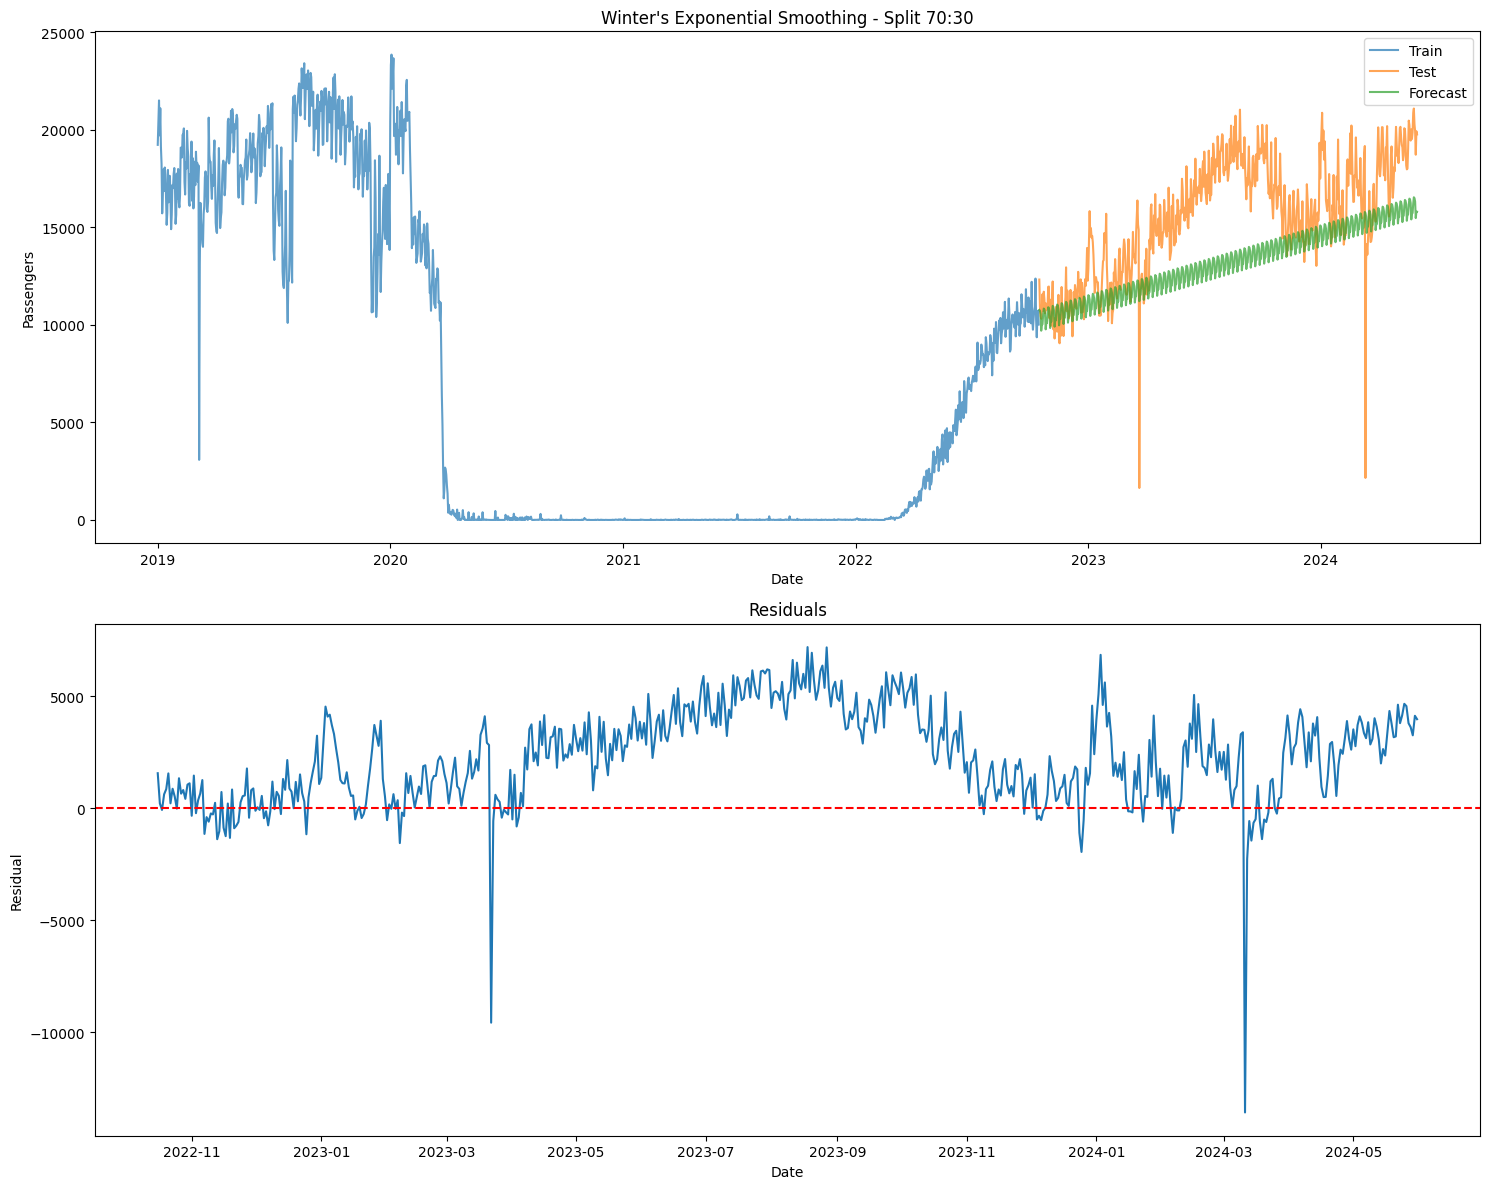

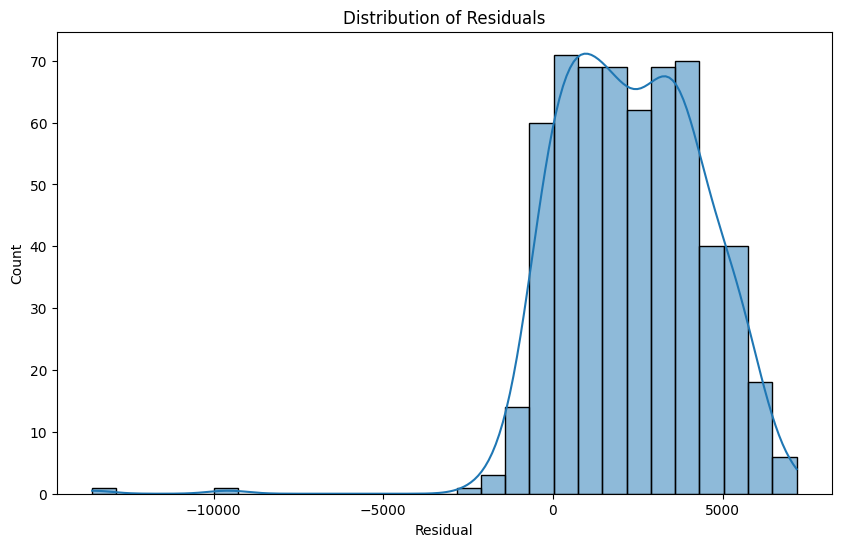

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


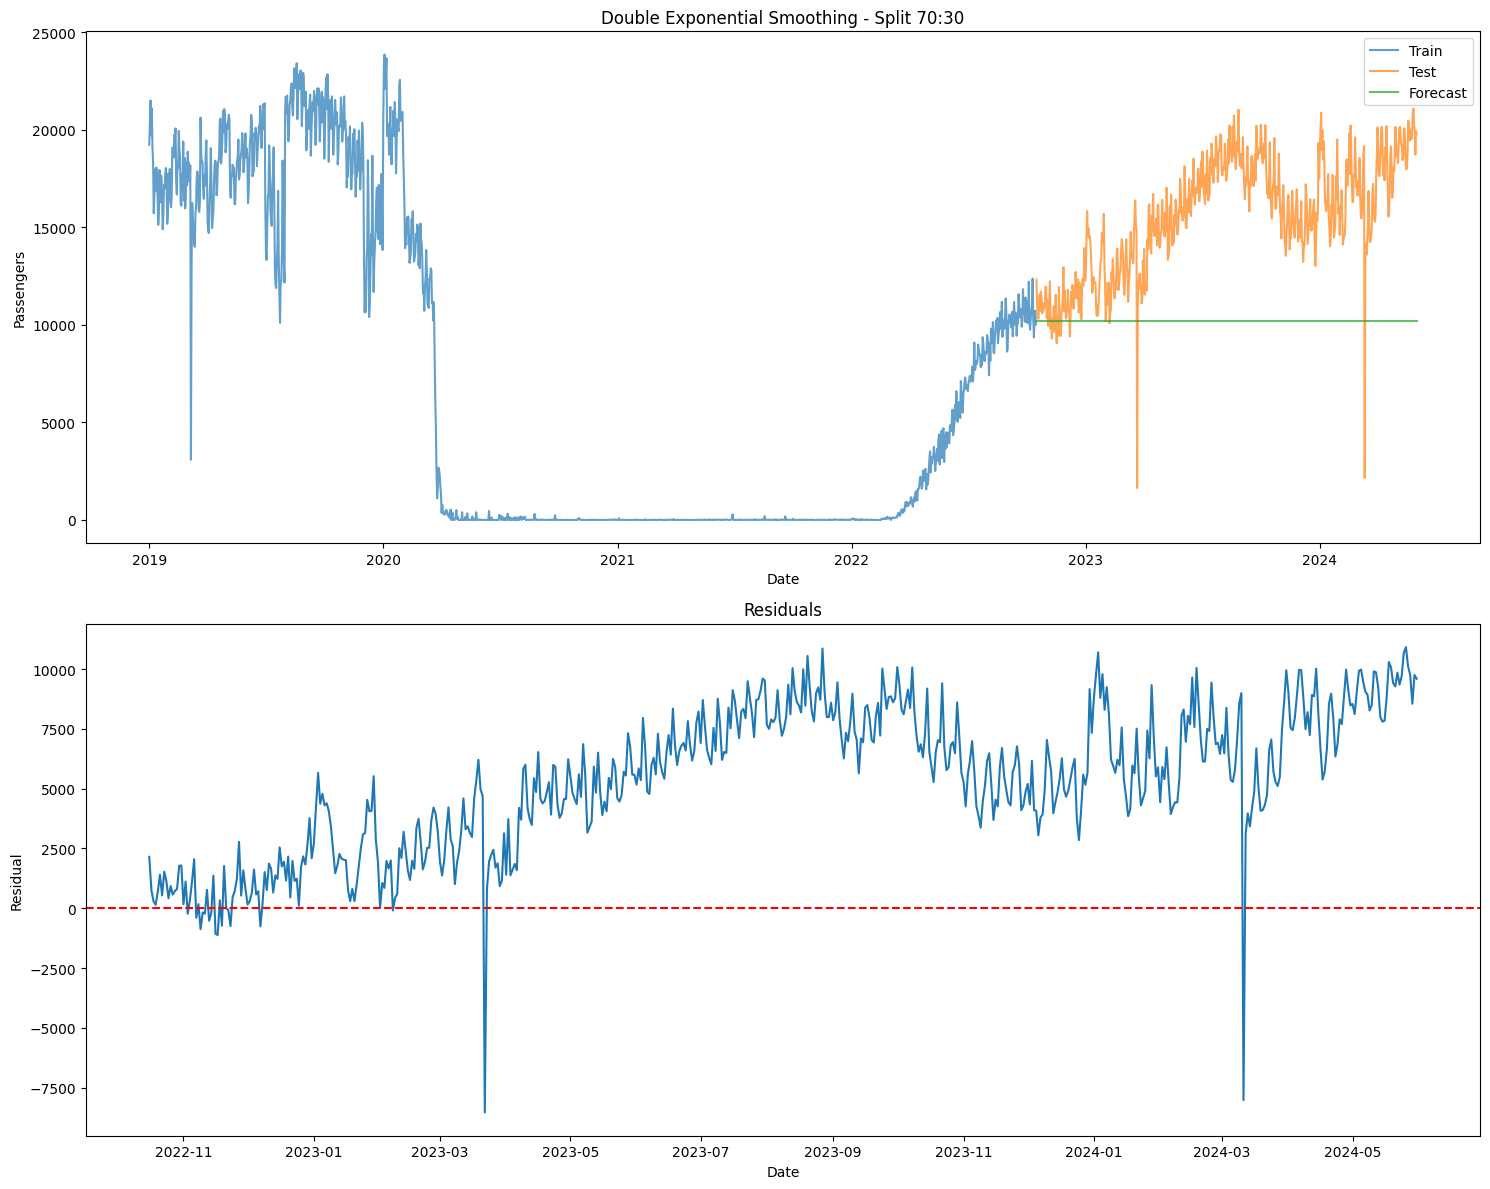

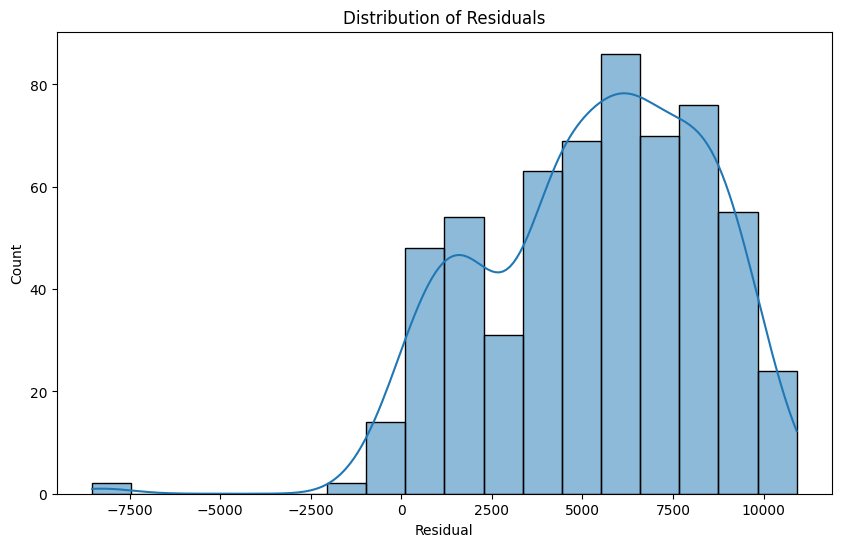

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


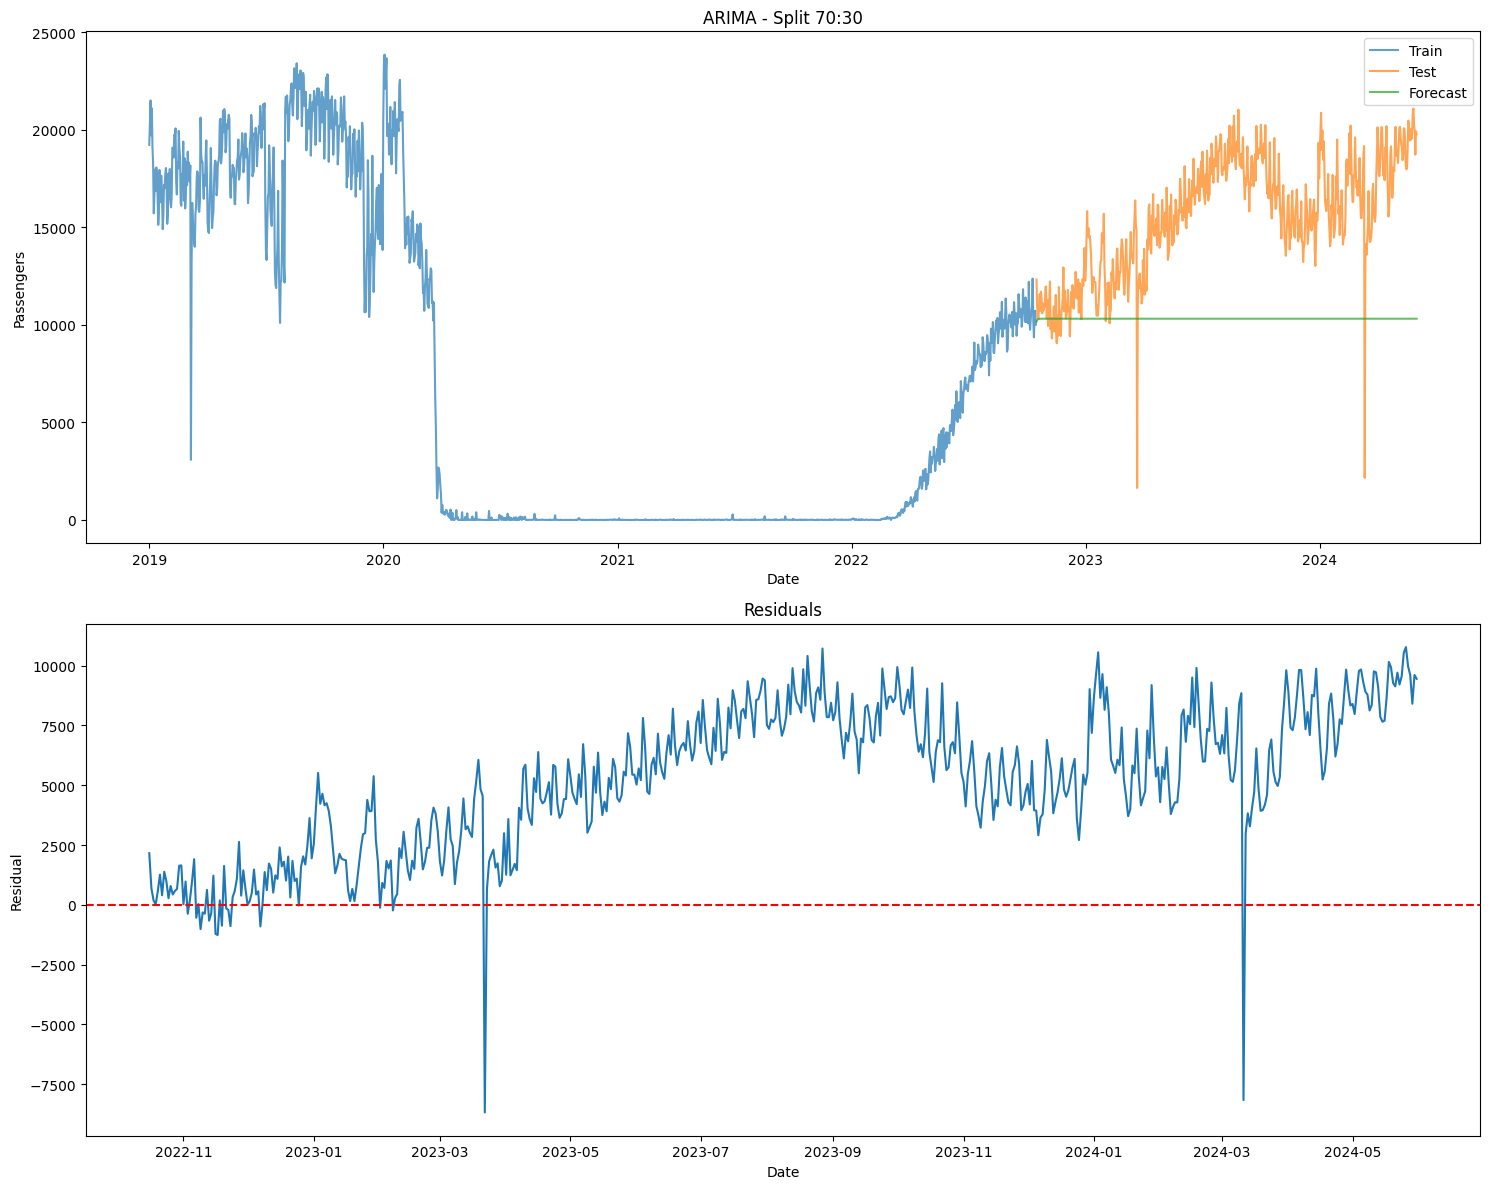

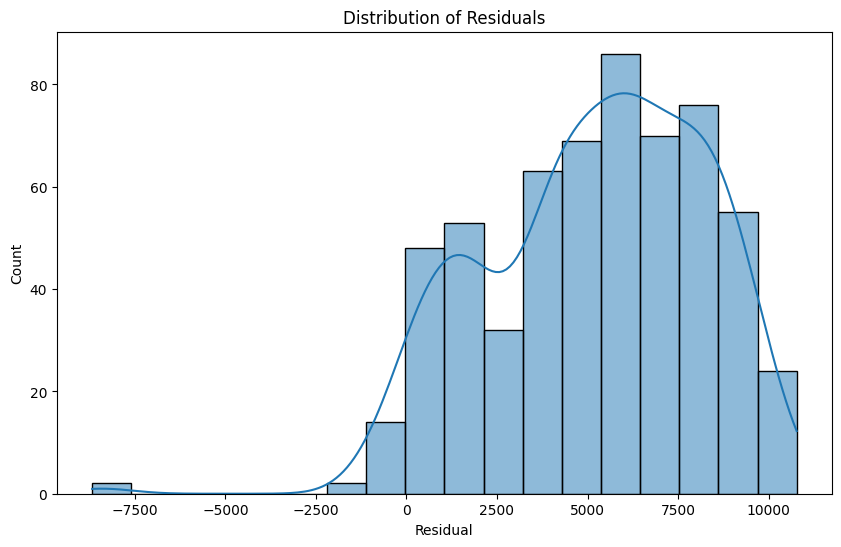

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


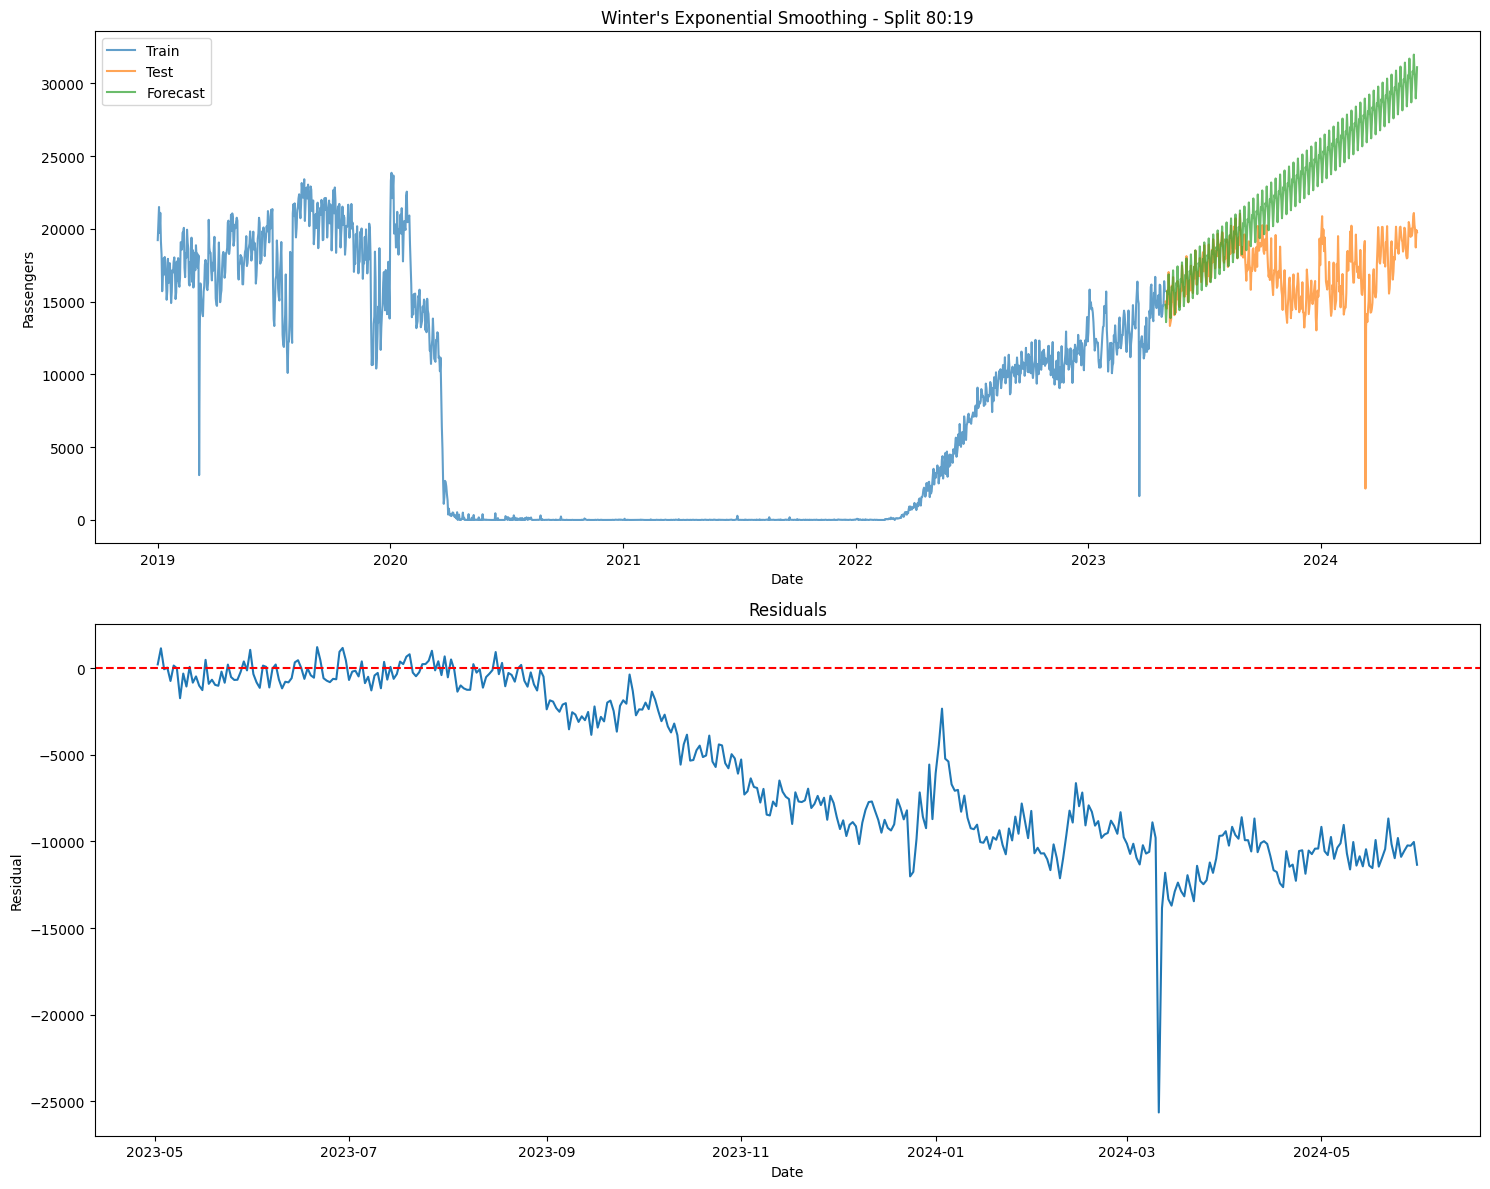

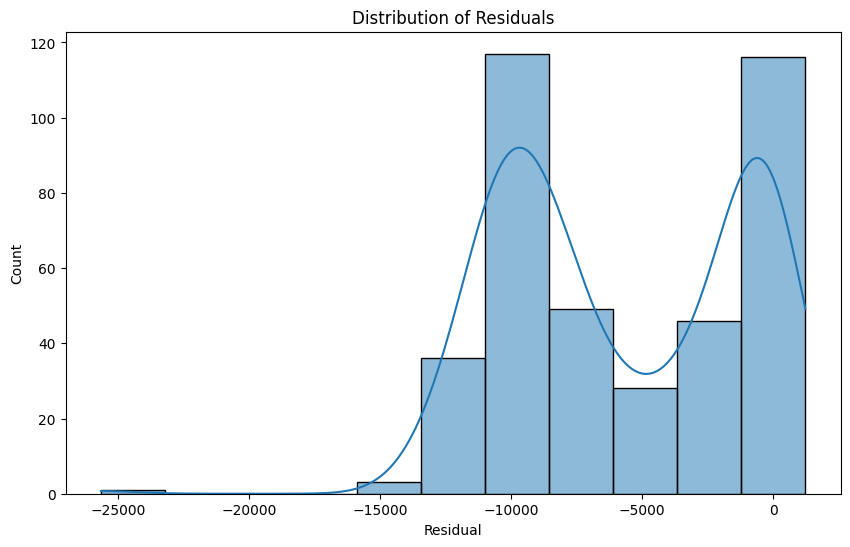

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


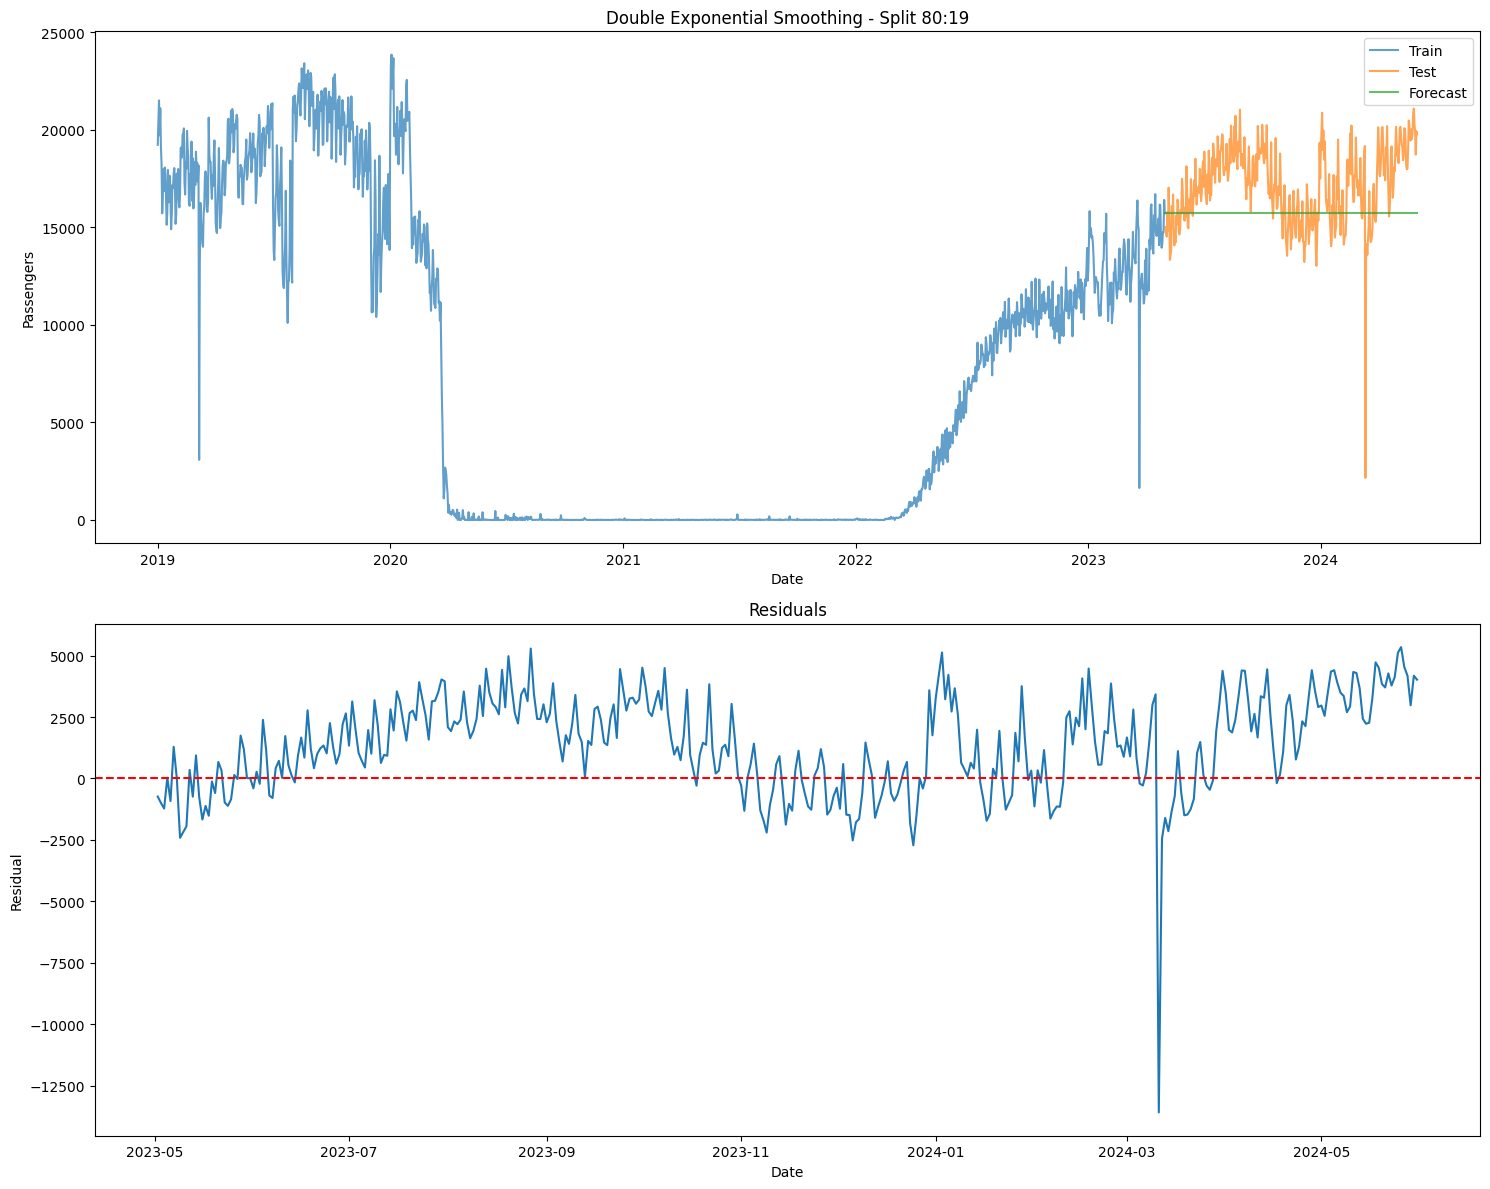

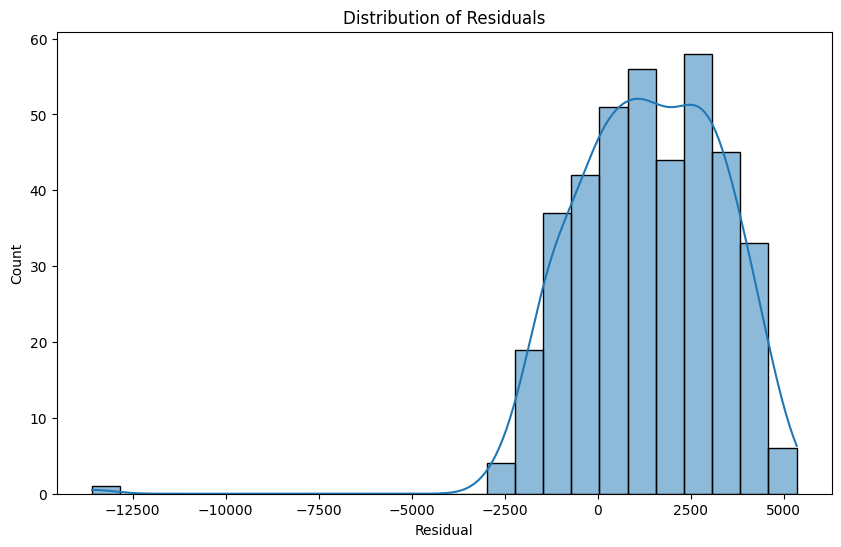

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


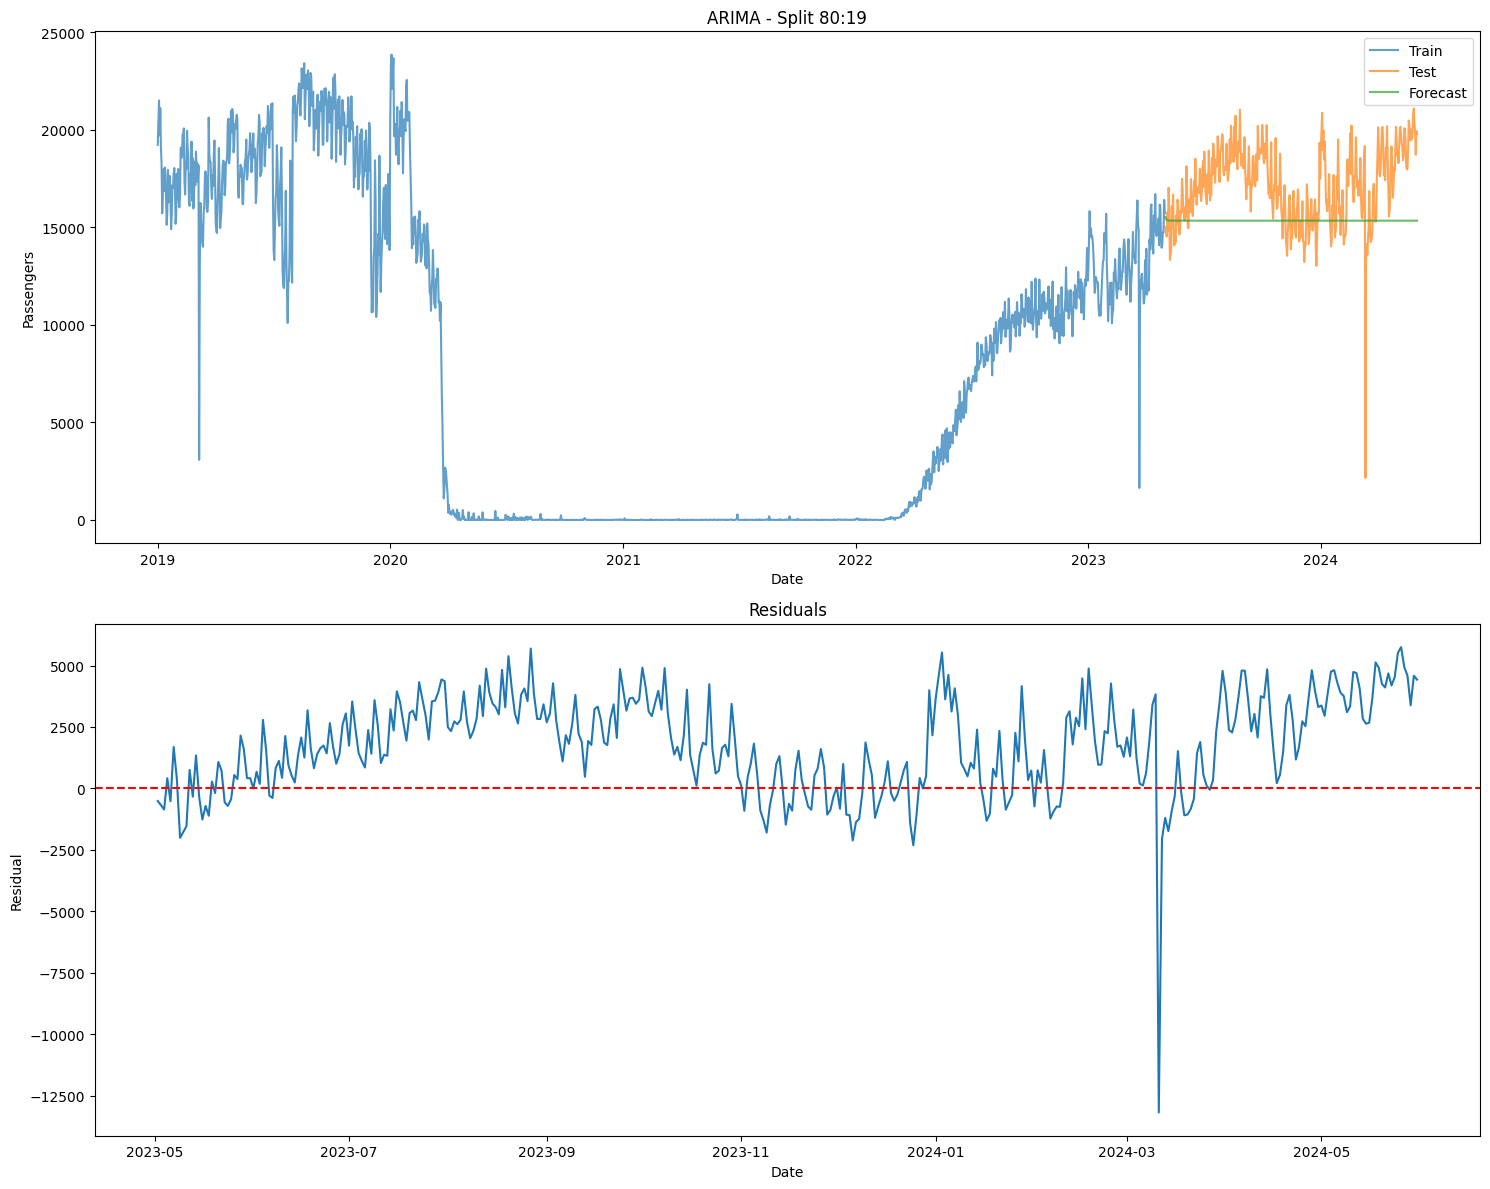

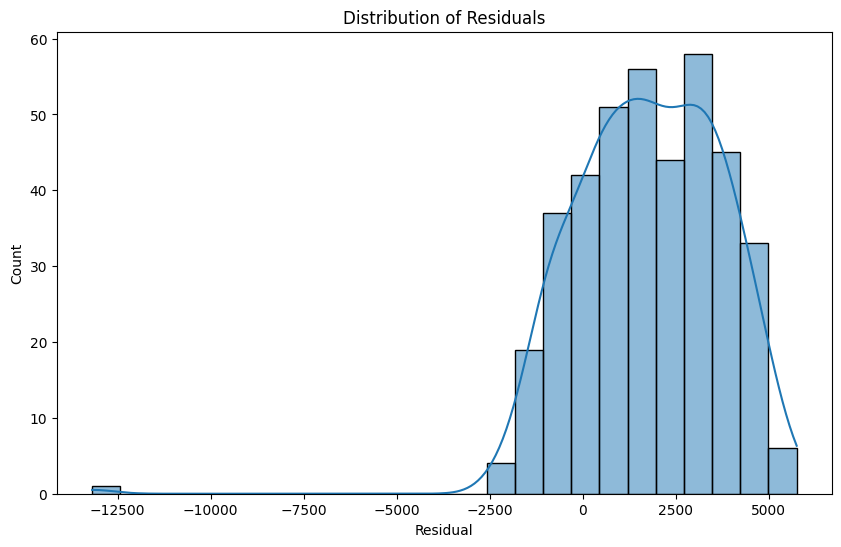

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


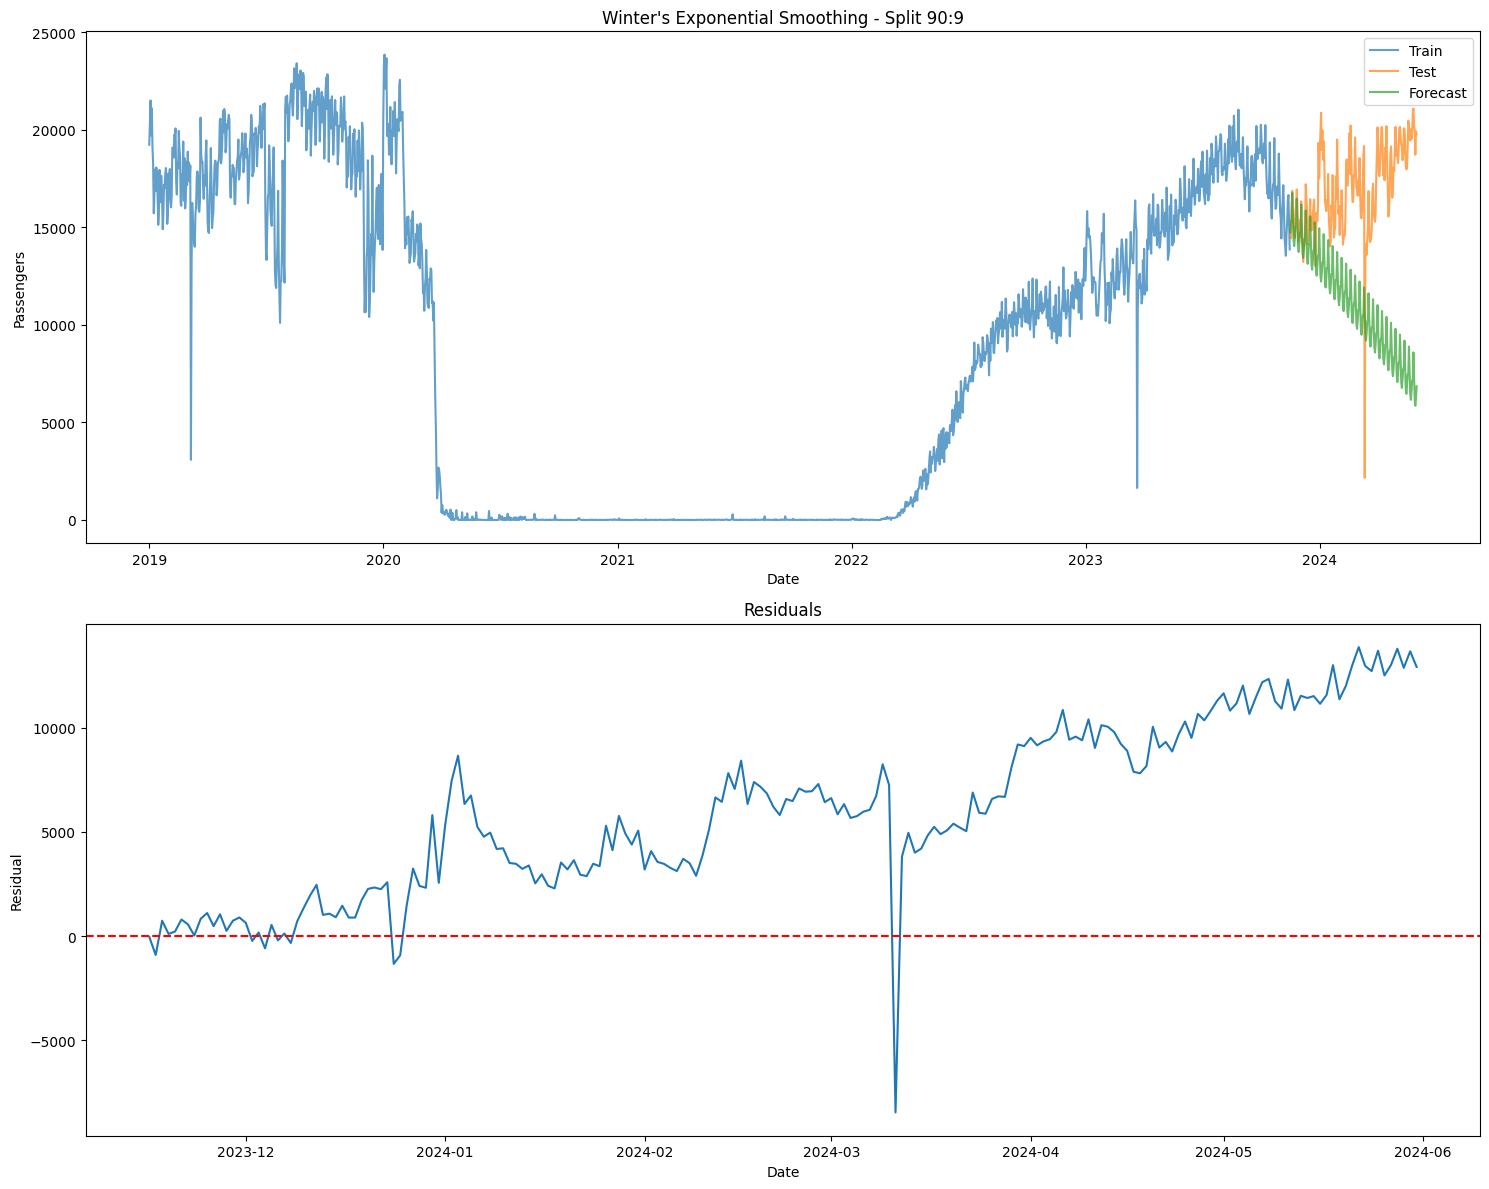

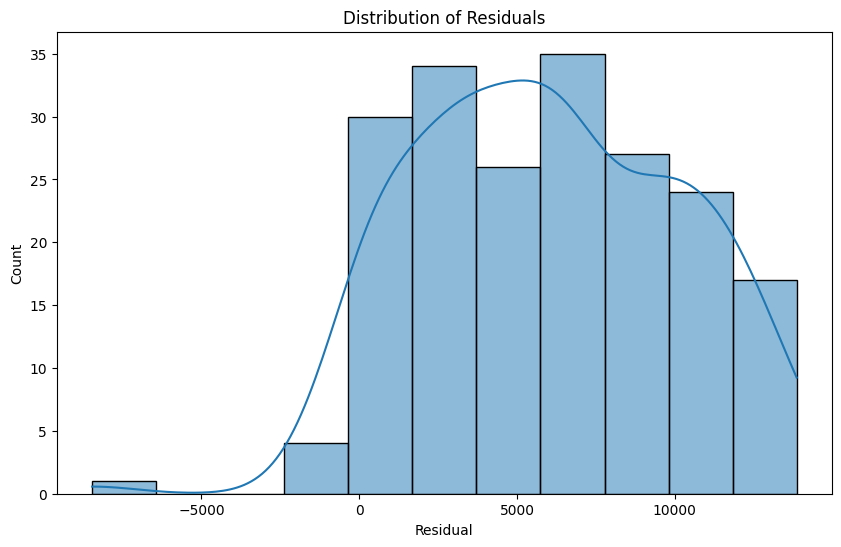

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


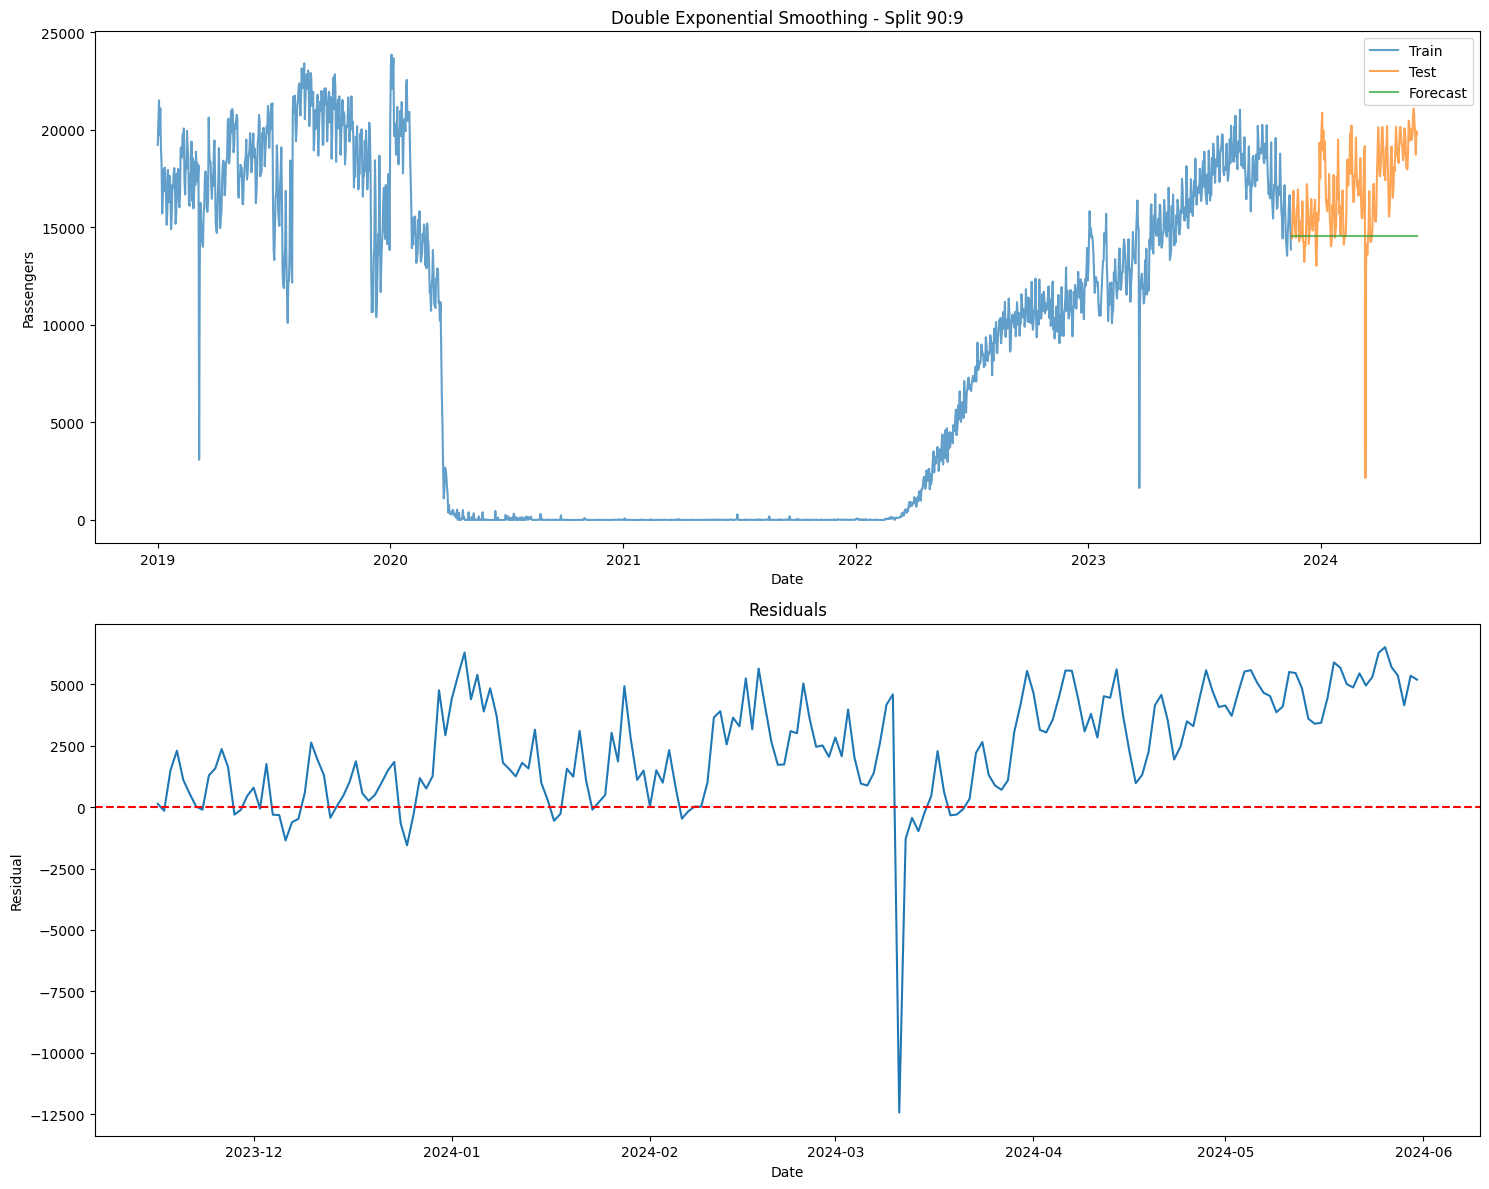

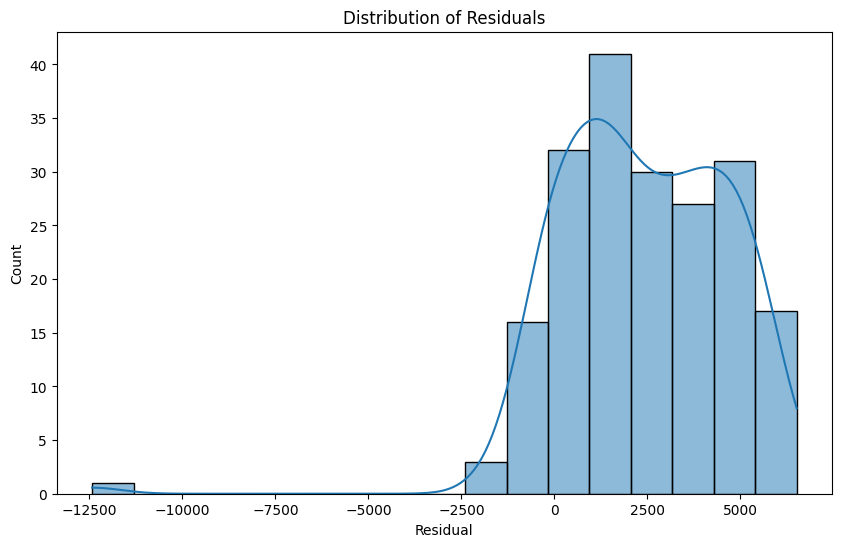

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


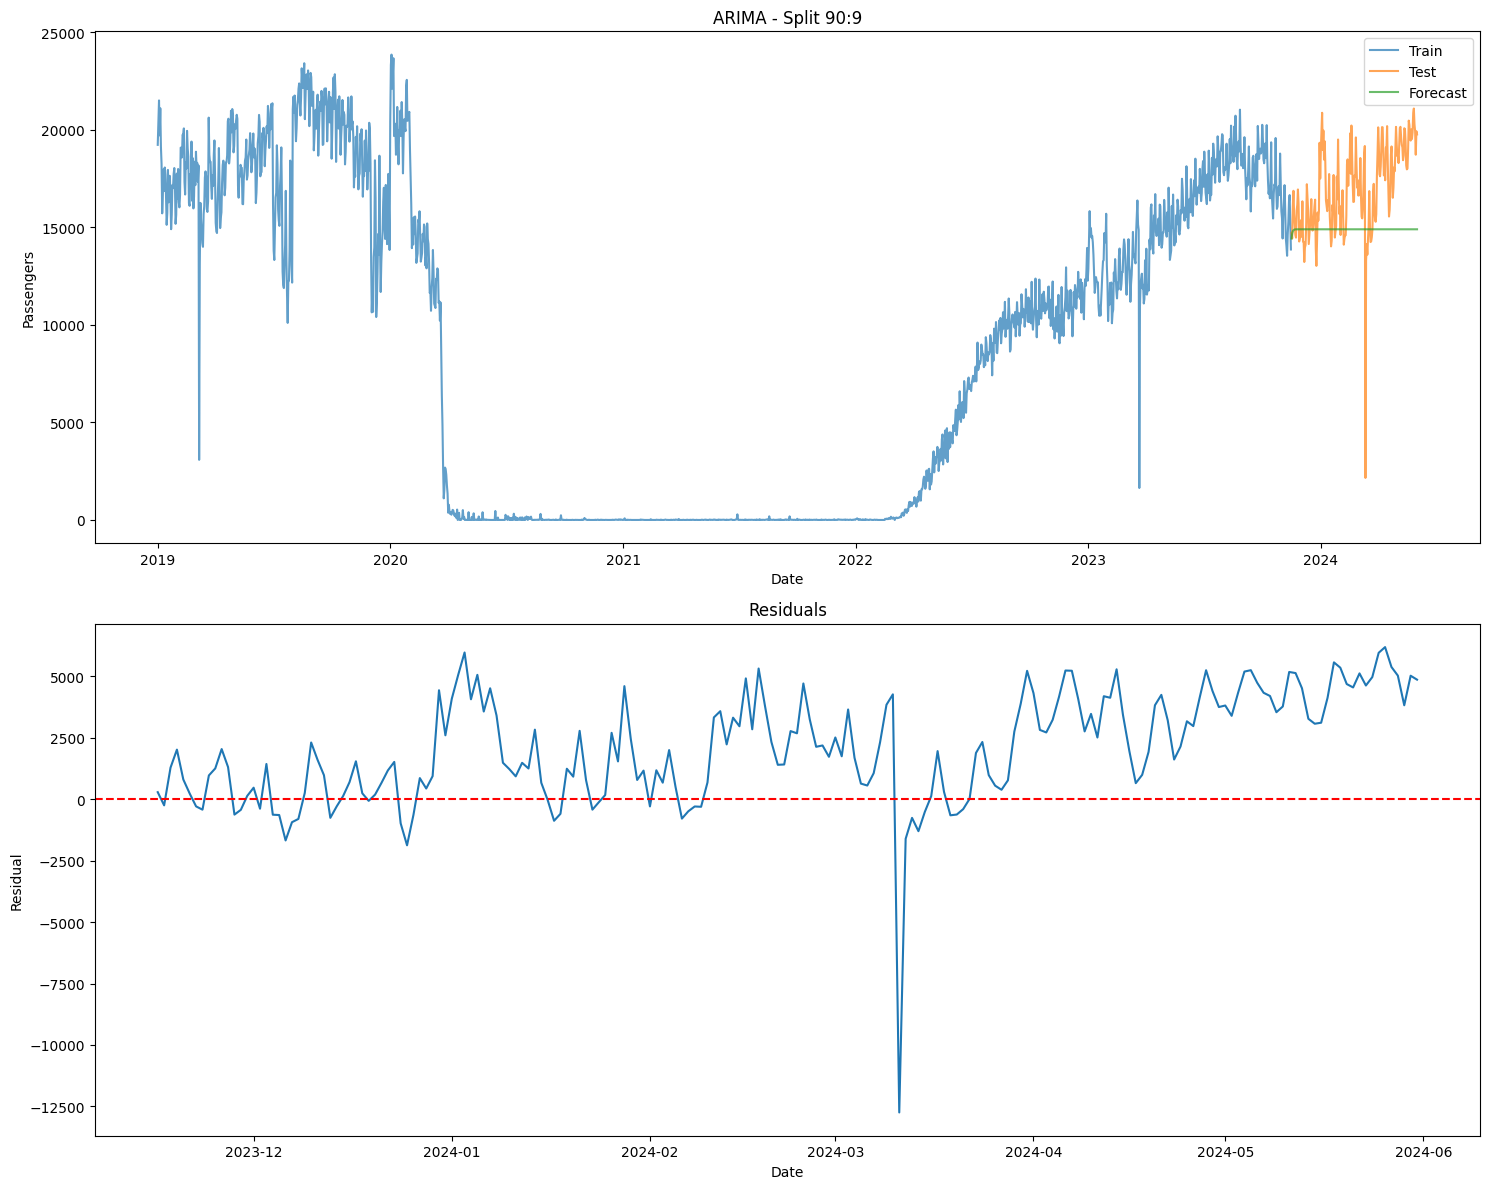

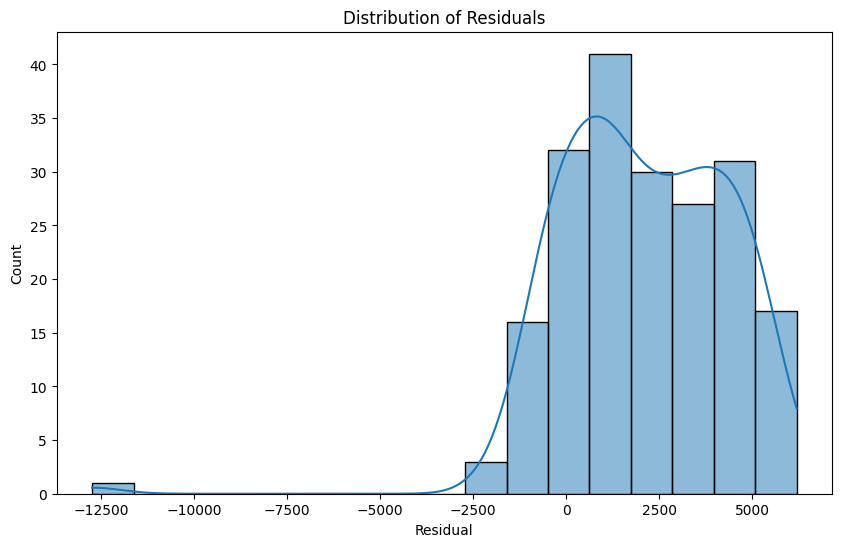

In [ ]:
# Sel 6: Loop untuk setiap pembagian data dan model
for split in splits:
    train_size = int(len(data) * split)
    train, test = data[:train_size], data[train_size:]

    for model_name in models:
        forecast, mad, mse, mape = forecast_and_evaluate(train['Penumpang'], test['Penumpang'], model_name)

        results.append({
            'Model': model_name,
            'Split': f"{int(split*100)}:{int((1-split)*100)}",
            'MAD': mad,
            'MSE': mse,
            'MAPE': mape
        })

        # Plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

        # Plot 1: Actual vs Forecast
        # adalah perbandingan antara nilai aktual dan nilai prediksi dari model
        ax1.plot(train.index, train['Penumpang'], label='Train', alpha=0.7)
        ax1.plot(test.index, test['Penumpang'], label='Test', alpha=0.7)
        ax1.plot(test.index, forecast, label='Forecast', alpha=0.7)
        ax1.set_title(f"{model_name} - Split {int(split*100)}:{int((1-split)*100)}")
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Passengers')
        ax1.legend()

        # Plot 2: Residuals
        # adalah selisih antara nilai aktual dan nilai prediksi dari model
        residuals = test['Penumpang'] - forecast
        ax2.plot(test.index, residuals)
        ax2.axhline(y=0, color='r', linestyle='--')
        ax2.set_title('Residuals')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Residual')

        plt.tight_layout()
        plt.show()

        # Additional plot: Residual distribution
        # adalah distribusi dari nilai residual yang dihasilkan oleh model
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True)
        plt.title('Distribution of Residuals')
        plt.xlabel('Residual')
        plt.show()


In [ ]:
results_df = pd.DataFrame(results)
results_df

,Model,Split,MAD,MSE,MAPE
0,Winter's Exponential Smoothing,70:30,2523.575637,9.786145e+06,16.814145
1,Double Exponential Smoothing,70:30,5426.079903,3.747722e+07,33.736956
2,ARIMA,70:30,5294.907497,3.599891e+07,32.912299
3,Winter's Exponential Smoothing,80:19,5852.928131,5.421806e+07,37.598818
4,Double Exponential Smoothing,80:19,1927.420221,5.772930e+06,12.121578
5,ARIMA,80:19,2158.456911,7.045056e+06,13.280664
6,Winter's Exponential Smoothing,90:9,6097.407307,5.237829e+07,35.798630
7,Double Exponential Smoothing,90:9,2646.430803,1.087026e+07,17.035819
8,ARIMA,90:9,2432.209358,9.433923e+06,15.940434
9,Winter's Exponential Smoothing,70:30,2523.575637,9.786145e+06,16.814145


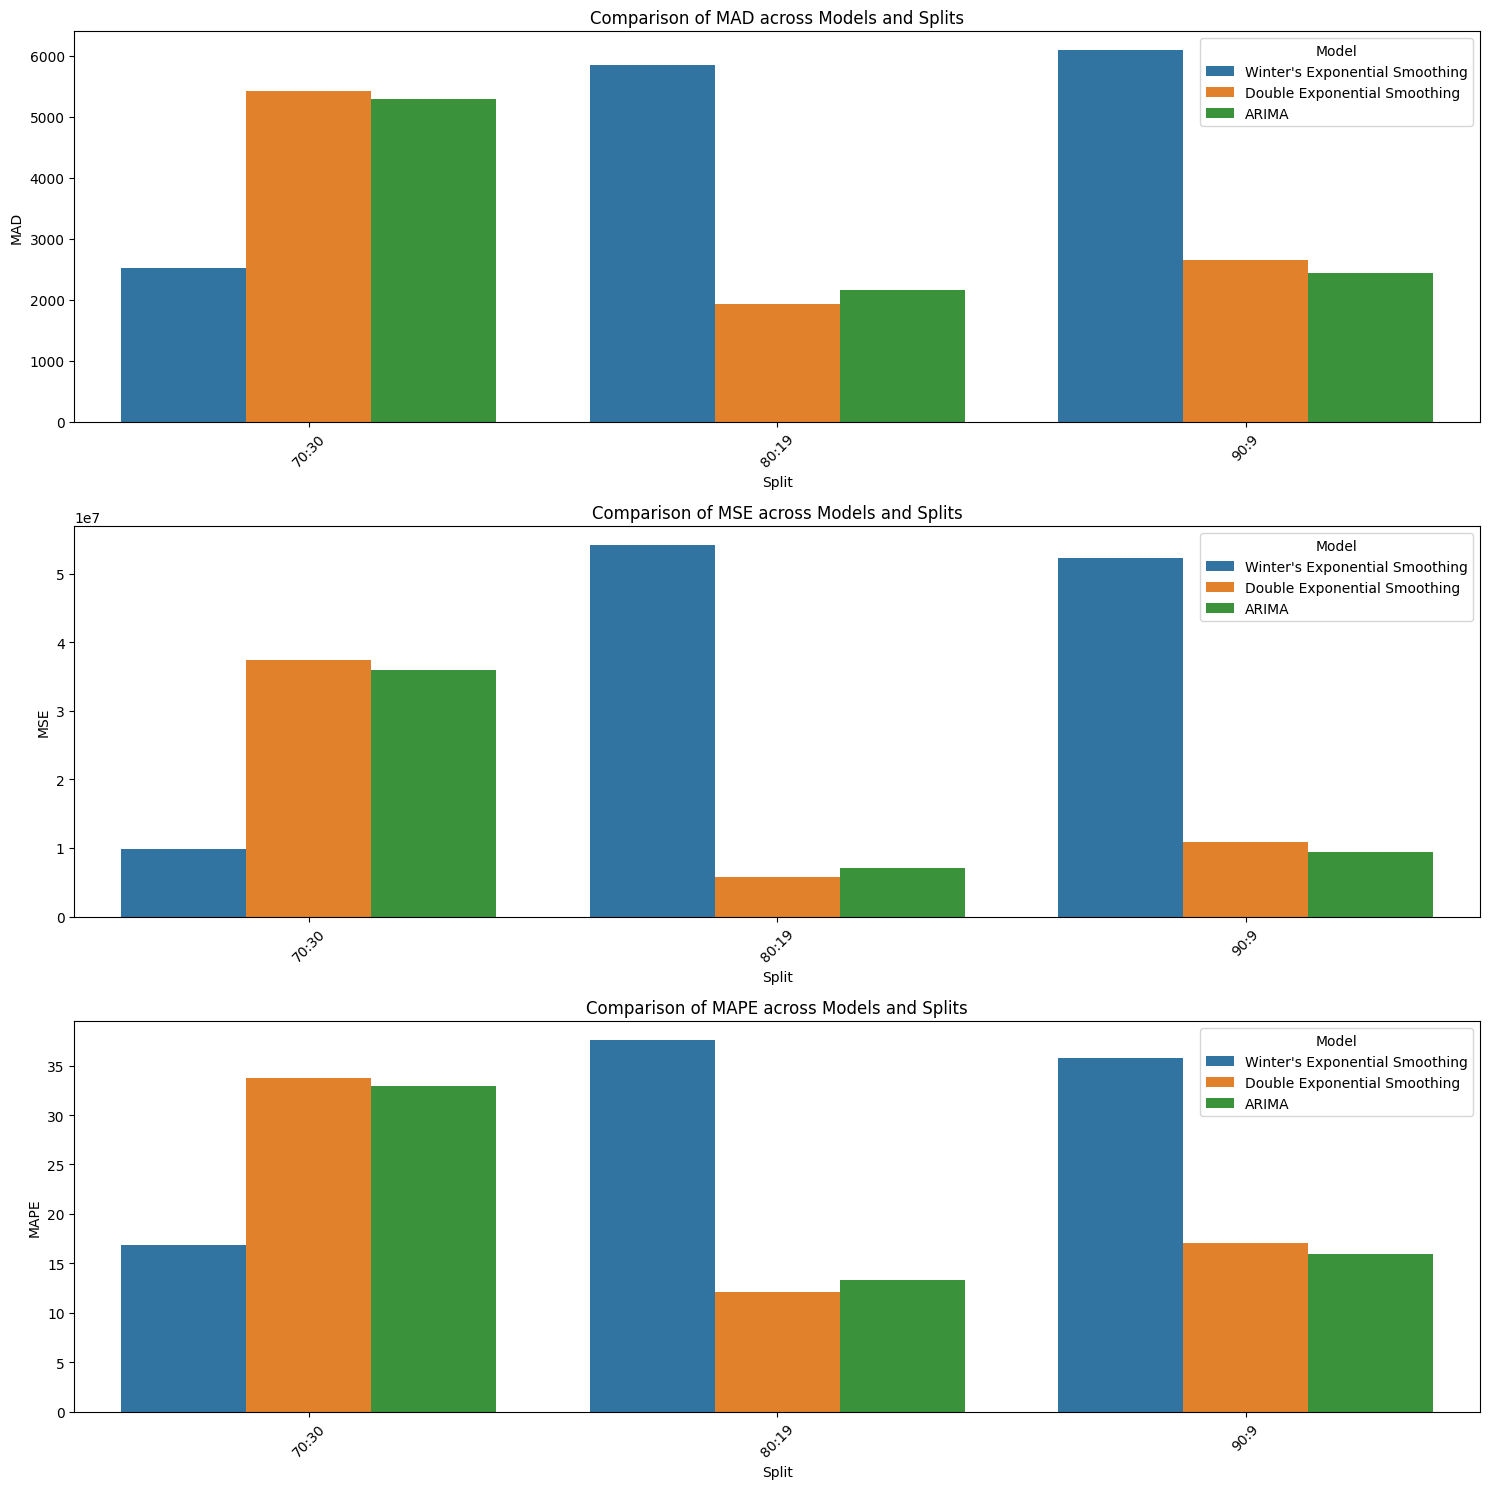

In [ ]:
# Sel 8: Visualisasi perbandingan model
plt.figure(figsize=(15, 15))

metrics = ['MAD', 'MSE', 'MAPE']
for i, metric in enumerate(metrics):
    plt.subplot(3, 1, i+1)
    sns.barplot(x='Split', y=metric, hue='Model', data=results_df)
    plt.title(f'Comparison of {metric} across Models and Splits')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# Sel 9: Menyimpan hasil ke CSV
results_df.to_csv('forecasting_results.csv', index=False)
print("Hasil forecasting disimpan dalam 'forecasting_results.csv'")


Hasil forecasting disimpan dalam 'forecasting_results.csv'
